# Retrieval-Augmented Generation Proof of Concept (RAGPoC)

Resources:
- https://github.com/yanndebray/programming-GPTs (page 60)
- https://jalammar.github.io/illustrated-word2vec/

## Hello world example of RAG with local vector search

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

In [2]:
paragraph = """
It was the best of times, it was the worst of times, it was the age 
of
wisdom, it was the age of foolishness, it was the epoch of belief, 
it
was the epoch of incredulity, it was the season of Light, it was the
season of Darkness, it was the spring of hope, it was the winter of
despair, we had everything before us, we had nothing before us, we 
were
all going direct to Heaven, we were all going direct the other way-
-in
short, the period was so far like the present period, that some of 
its
noisiest authorities insisted on its being received, for good or for
evil, in the superlative degree of comparison only.
"""
sentences = paragraph.replace("\n"," ").split(", ")
sentence = sentences[0]
sentence

' It was the best of times'

In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2') # or 'all-mpnet-base-v2'
# Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)
print(embedding.shape)

(384,)


In [4]:
embeddings = model.encode(sentences)
print(embeddings.shape)

(18, 384)


In [10]:
embeddings[0][0:42]

array([-0.04521136,  0.07174971,  0.01724942, -0.03167224,  0.04766259,
       -0.00803214,  0.01217398,  0.05781353, -0.0235216 ,  0.00054155,
       -0.00585707,  0.1644522 ,  0.08721226,  0.05755439, -0.00970987,
        0.02569514,  0.03181614,  0.00486323, -0.02249885, -0.03809837,
       -0.05676328, -0.0270306 ,  0.01227824,  0.04930028,  0.00922562,
        0.03006623,  0.00722768,  0.06361192, -0.02892416,  0.0343357 ,
       -0.03903637, -0.02014589,  0.00092694,  0.01156489, -0.05669314,
        0.00326512,  0.01083136, -0.06769545,  0.02461126, -0.00084432,
        0.0038335 , -0.03420864], dtype=float32)

Comparing embeddings visually, inspired from Jay Alammar 

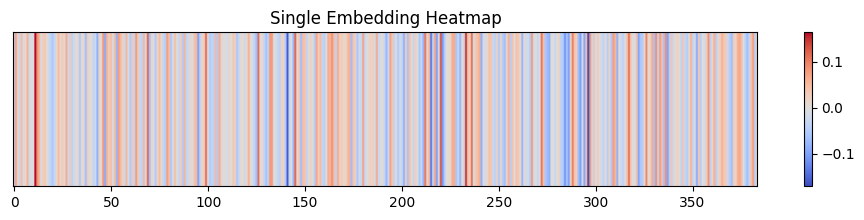

In [36]:
# Function to visualize a single embedding as a heatmap
def plot_single_embedding(embedding):
    _, ax = plt.subplots(figsize=(12, 2))
    data = embedding.reshape(1, -1)  # Reshape to 2D array for heatmap
    im = ax.imshow(data, cmap="coolwarm", aspect="auto")
    ax.set_yticks([])
    # Add color bar
    plt.colorbar(im, ax=ax)
    ax.set_title("Single Embedding Heatmap")
    plt.show()
plot_single_embedding(embedding)

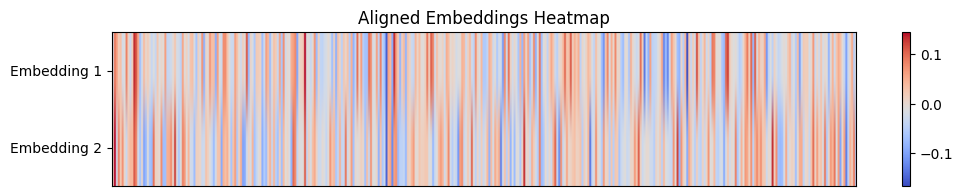

In [34]:
# Function to plot embeddings aligned
def plot_aligned_embeddings(embedding1, embedding2):
    fig, ax = plt.subplots(figsize=(12, 2))

    # Stack the embeddings for aligned visualization
    aligned_embeddings = np.vstack([embedding1, embedding2])

    # Create the heatmap
    im = ax.imshow(aligned_embeddings, cmap="coolwarm", aspect="auto")

    # Set labels
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Embedding 1", "Embedding 2"])
    ax.set_xticks([])
    
    # Add color bar
    plt.colorbar(im, ax=ax)
    ax.set_title("Aligned Embeddings Heatmap")
    plt.show()

# Call the function
plot_aligned_embeddings(embeddings[1], embeddings[2])

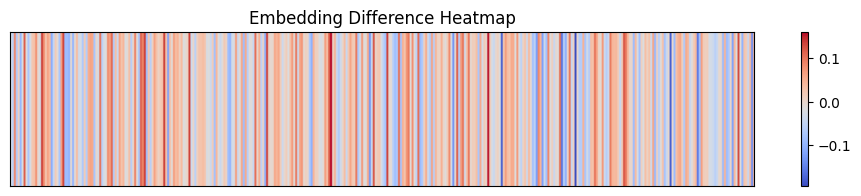

In [31]:
# Function to compare one embedding over another
def plot_difference_embeddings(embedding1, embedding2):
    # Compute the difference
    difference = embedding1 - embedding2

    # Plot the difference as a heatmap
    fig, ax = plt.subplots(figsize=(12, 2))
    data = difference.reshape(1, -1)  # Reshape to 2D array for heatmap
    im = ax.imshow(data, cmap="coolwarm", aspect="auto")

    # Remove xtick labels for cleaner visualization
    ax.set_xticks([])
    ax.set_yticks([])

    # Add color bar
    plt.colorbar(im, ax=ax)
    ax.set_title("Embedding Difference Heatmap")
    plt.show()

# Call the function
plot_difference_embeddings(embeddings[1], embeddings[2])

## Cosine similarity and Similarity search

In [38]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)
sentences[0], sentences[1], cosine_similarity(embeddings[0], embeddings[1])


(' It was the best of times',
 'it was the worst of times',
 np.float32(0.7910879))

In [39]:
sentences[2], sentences[3], cosine_similarity(embeddings[2], embeddings[3])


('it was the age  of wisdom',
 'it was the age of foolishness',
 np.float32(0.71510106))

In [40]:
import faiss

# Dimension of the embeddings
d = embeddings.shape[1]

# Create a FAISS index
index = faiss.IndexFlatL2(d)

# Add embeddings to the index
index.add(embeddings)

# Check the number of vectors in the index
print(f"Number of vectors in the index: {index.ntotal}")

Number of vectors in the index: 18


In [42]:
# Encode the sentence "good times"
query_sentence = "good times"
query_embedding = model.encode(query_sentence)

# Perform the search
k = 5  # Number of nearest neighbors to retrieve
distances, indices = index.search(np.array([query_embedding]), k)

# Print the results
print("Nearest neighbors (smaller is better):")
for i, idx in enumerate(indices[0]):
    print(f"Sentence: {sentences[idx]}, Distance: {distances[0][i]}")

Nearest neighbors (smaller is better):
Sentence:  It was the best of times, Distance: 0.6442606449127197
Sentence: it was the worst of times, Distance: 0.8687978982925415
Sentence: we had everything before us, Distance: 1.409303069114685
Sentence: it was the spring of hope, Distance: 1.4114552736282349
Sentence: for good or for evil, Distance: 1.428534984588623
